In [485]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [486]:
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=UserWarning)

In [487]:
import pandas as pd
import numpy as np
from utilities import *
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

In [488]:
from sklearn import set_config
set_config(transform_output="pandas")
set_config(display='diagram')

In [489]:
X_train, y_train, X_test, y_test = load_data()
selected_columns = np.load("./data/selected_columns.npy", allow_pickle=True)
X_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


In [490]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
model_errors = {}
regresion_function = DecisionTreeRegressor()

### Baseline

In [491]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', CategoricalEncoder())
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, make_column_selector(dtype_include=object)),
    ('num', numerical_pipeline, make_column_selector(dtype_exclude=object)),
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regresion_function)
])
model_errors["1.baseline"] = test_model(model, X_train, y_train, X_test, y_test)

### Remove Columns with too much nulls

In [492]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', CategoricalEncoder())
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, make_column_selector(dtype_include=object)),
    ('num', numerical_pipeline, make_column_selector(dtype_exclude=object)),
])
model = Pipeline(steps=[
    ('column_dropper', ColumnDropperTransformer()),
    ('preprocessor', preprocessor),
    ('regressor', regresion_function)
])
model_errors["2.-nullColumns"] = test_model(model, X_train, y_train, X_test, y_test)

### Add One Hot Encoder

In [493]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, make_column_selector(dtype_include=object)),
    ('num', numerical_pipeline, make_column_selector(dtype_exclude=object)),
])
model = Pipeline(steps=[
    ('column_dropper', ColumnDropperTransformer()),
    ('preprocessor', preprocessor),
    ('regressor', regresion_function)
])
model_errors["3.+OneHotEncoder"] = test_model(model, X_train, y_train, X_test, y_test)

### Normalize numeric data with MinMax

In [494]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('normalizer', MinMaxScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, make_column_selector(dtype_include=object)),
    ('num', numerical_pipeline, make_column_selector(dtype_exclude=object)),
])
model = Pipeline(steps=[
    ('column_dropper', ColumnDropperTransformer()),
    ('preprocessor', preprocessor),
    ('regressor', regresion_function)
])
model_errors["4.+numNormalize"] = test_model(model, X_train, y_train, X_test, y_test)

### Remove outliers

In [495]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop="if_binary", max_categories=10, min_frequency=0.001, sparse_output=False))
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('remove_outliers', OutlierTransformer()),
    ('normalizer', MinMaxScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, make_column_selector(dtype_include=object)),
    ('num', numerical_pipeline, make_column_selector(dtype_exclude=object)),
])
model = Pipeline(steps=[
    ('column_dropper', ColumnDropperTransformer()),
    ('preprocessor', preprocessor),
    ('regressor', regresion_function)
])
model_errors["5.-outliers"] = test_model(model, X_train, y_train, X_test, y_test)

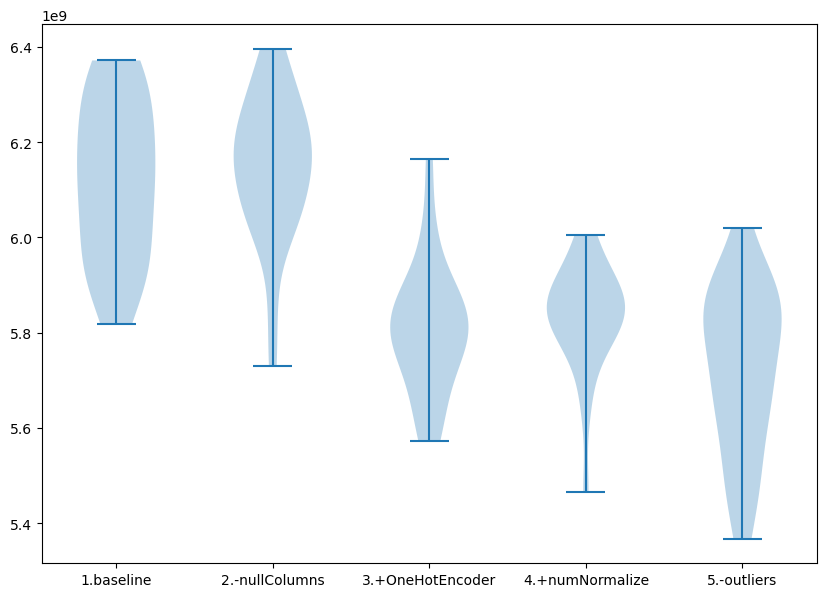

In [496]:
compare_errors(model_errors)